# Scripts related to venv
### Open a terminal
- .venv\Scripts\activate
- py -m pip install --upgrade pip
- py -m pip install requests
- py -m pip freeze > requirements.txt
- py -m pip install -r requirements.txt

# AWS Article
- https://induraj2020.medium.com/how-to-access-the-s3-bucket-using-python-ecdbe5ebc45f

In [87]:
import os
from PIL import Image
import boto3
import math
import json
import matplotlib.pyplot as plt
import io
import numpy as np
import warnings
import requests
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, Model # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import f1_score, accuracy_score, auc, roc_curve
warnings.filterwarnings("ignore")

In [88]:
# Load individual images and convert to RGB
def load_image(bucket_name, image_key, target_size=(128, 128)):
    s3 = boto3.client('s3')
    image_data = s3.get_object(Bucket=bucket_name, Key=image_key)['Body'].read()

    image = Image.open(io.BytesIO(image_data)).convert('RGB')

    image = image.resize(target_size)

    return np.array(image) / 255.0 # Standardize inputs

In [89]:
# Load images from S3 account
def load_images(bucket_name, dataset_path, target_size=(128, 128)):
    images = []
    labels = []
    label_mapping = {}
    s3 = boto3.client('s3')
    paginator = s3.get_paginator('list_objects_v2')

    for i, page in enumerate(paginator.paginate(Bucket=bucket_name, Prefix=dataset_path)):
        if 'Contents' not in page:
            continue
        
        for obj in page['Contents']:
            image_key = obj['Key']
            if image_key.endswith(".png"):
                genre_label = image_key.split('/')[-2]

                if genre_label not in label_mapping:
                    label_mapping[genre_label] = len(label_mapping)

                image_array = load_image(bucket_name, image_key, target_size)

                images.append(image_array)
                labels.append(label_mapping[genre_label])

    return np.array(images), np.array(labels)

In [90]:
images, labels = load_images(bucket_name='flights12345', dataset_path=r"Data/images_original")

## Create training/validation/testing


In [91]:
np.random.seed(123)

# Set training/validation/testing size
train_size = int(0.7 * 999)
test_size = int(0.15 * 999)
validation_size = int(0.15 * 999)

# Set coding for each group and shuffle 
groups = np.array([0] * train_size + [1] * test_size + [2] * validation_size)
np.random.shuffle(groups)

In [92]:
train_images, validation_images, test_images = [], [], []
train_labels, validation_labels, test_labels = np.array([]), np.array([]), np.array([])

# Add image and label to each group depending on label
for i, group in enumerate(groups):
    if group == 0:
        train_images.append(images[i])
        train_labels = np.append(train_labels, int(labels[i]))
    elif group == 1:
        validation_images.append(images[i])
        validation_labels = np.append(validation_labels, int(labels[i]))
    else:
        test_images.append(images[i])
        test_labels = np.append(test_labels, int(labels[i]))

In [93]:
train_images, validation_images, test_images = np.array(train_images), np.array(validation_images), np.array(test_images)
# One hot encode labels
train_labels, validation_labels, test_labels = to_categorical(train_labels, num_classes=10), to_categorical(validation_labels, num_classes=10), to_categorical(test_labels, num_classes=10)

## Feed into FCN for feature extraction


In [94]:
def build_fcn(input_shape=(train_images.shape[1:]), num_classes=10):
    model = models.Sequential()

    # Input layer
    model.add(layers.Input(shape=input_shape))

    # Conv1: 3×3 convolution, 128 filters
    model.add(layers.Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 4), padding="same"))

    # Conv2: 3×3 convolution, 384 filters
    model.add(layers.Conv2D(384, (3, 3), padding="same", activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(4, 4), padding="same"))

    # Conv3: 3×3 convolution, 768 filters
    model.add(layers.Conv2D(768, (3, 3), padding="same", activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), padding="same"))

    # Conv4: 3×3 convolution, 2048 filters
    model.add(layers.Conv2D(2048, (3, 3), padding="same", activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(4, 4), padding="same"))  

    # Output layer: 1×1 convolutional layer for 10 classes
    model.add(layers.Conv2D(num_classes, (1, 1), activation="sigmoid"))

    model.add(layers.GlobalAveragePooling2D())

    return model
    

In [95]:
model_fcn = build_fcn()
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_fcn.compile(optimizer=adam_opt, loss="binary_crossentropy", metrics=["accuracy"])

# Early stopping is used to find optimum number of epochs
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

model_fcn.fit(train_images, train_labels, validation_data=(validation_images,validation_labels), batch_size=16, epochs=100, callbacks=[early_stopping])

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 39s 828ms/step - accuracy: 0.0969 - loss: 0.4182 - val_accuracy: 0.1074 - val_loss: 0.3262
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 35s 798ms/step - accuracy: 0.0854 - loss: 0.3263 - val_accuracy: 0.1409 - val_loss: 0.3225
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 824ms/step - accuracy: 0.2132 - loss: 0.3124 - val_accuracy: 0.2819 - val_loss: 0.2947
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 35s 801ms/step - accuracy: 0.2501 - loss: 0.2904 - val_accuracy: 0.3154 - val_loss: 0.2859
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 35s 799ms/step - accuracy: 0.3193 - loss: 0.2812 - val_accuracy: 0.3356 - val_loss: 0.2748
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 819ms/step - accuracy: 0.3161 - loss: 0.2726 - val_accuracy: 0.3087 - val_loss: 0.2811
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 830ms/step - accuracy: 0.3453 - loss: 0.2623 - val_accuracy: 0.3423 - val_loss: 0.2678
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 823ms/step - accuracy: 0.4015 - loss: 0.2548 - 

## Feed into SVM

In [96]:
# Get features from penultimate layer
penultimate_layer_model = Model(inputs=model_fcn.inputs, outputs=model_fcn.layers[-2].output)
# Get predictions to use as training data
features_train = penultimate_layer_model.predict(train_images)
# Reshape data
flattened_features_train = features_train.reshape(features_train.shape[0], -1)
# Scale data 
scaler_train = StandardScaler()
scaled_features_train = scaler_train.fit_transform(flattened_features_train)
param_grid = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],  
              'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}

# Hyperparameter tune with grid search
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose=3)
grid.fit(scaled_features_train, [np.argmax(i) for i in train_labels])

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step
Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END .....C=1e-05, gamma=10, kernel=rbf;, score=0.107 total time=   0.0s
[CV 2/5] END .....C=1e-05, gamma=10, kernel=rbf;, score=0.107 total time=   0.0s
[CV 3/5] END .....C=1e-05, gamma=10, kernel=rbf;, score=0.107 total time=   0.0s
[CV 4/5] END .....C=1e-05, gamma=10, kernel=rbf;, score=0.100 total time=   0.0s
[CV 5/5] END .....C=1e-05, gamma=10, kernel=rbf;, score=0.108 total time=   0.0s
[CV 1/5] END ......C=1e-05, gamma=1, kernel=rbf;, score=0.107 total time=   0.0s
[CV 2/5] END ......C=1e-05, gamma=1, kernel=rbf;, score=0.107 total time=   0.0s
[CV 3/5] END ......C=1e-05, gamma=1, kernel=rbf;, score=0.107 total time=   0.0s
[CV 4/5] END ......C=1e-05, gamma=1, kernel=rbf;, score=0.143 total time=   0.0s
[CV 5/5] END ......C=1e-05, gamma=1, kernel=rbf;, score=0.108 total time=   0.0s
[CV 1/5] END ....C=1e-05, gamma=0.1, kernel=rbf;, score=0.107 total time=   0.0s
[CV 2/

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [97]:
grid.best_params_

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

## Feed into Random Forest

In [98]:
rf = RandomForestClassifier(n_estimators=1000)

rf.fit(scaled_features_train, [np.argmax(i) for i in train_labels])

RandomForestClassifier(n_estimators=1000)

## Testing SVM

In [99]:
features_test = penultimate_layer_model.predict(test_images)

flattened_features_test = features_test.reshape(features_test.shape[0], -1)

scaler_test = StandardScaler()
scaled_features_test = scaler_test.fit_transform(flattened_features_test)

test_pred = grid.predict(scaled_features_test)
accuracy_score([np.argmax(i) for i in test_labels], test_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step


0.6778523489932886

## Testing Random Forest

In [100]:
test_pred_rf = rf.predict(scaled_features_test)
accuracy_score([np.argmax(i) for i in test_labels], test_pred_rf)

0.6577181208053692

## Visualizations

In [101]:
train_accuracy = model_fcn.history.history['accuracy']
val_accuracy = model_fcn.history.history['val_accuracy']  # Training accuracy

In [102]:
val_loss = model_fcn.history.history['val_loss']

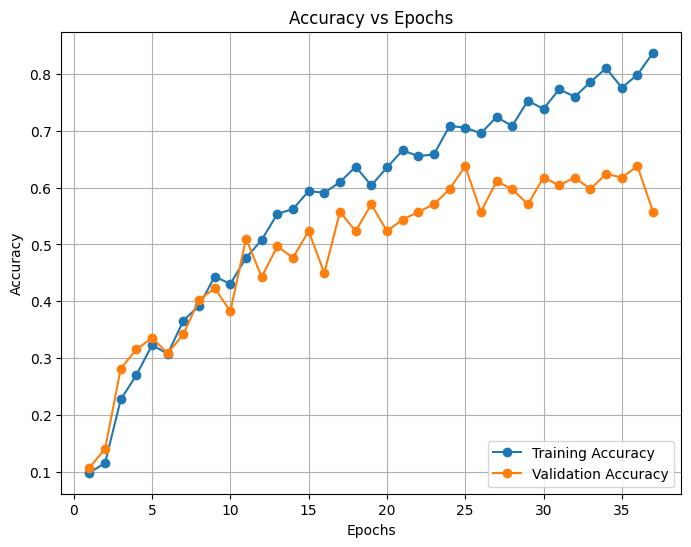

In [103]:
# Plotting accuracy vs. epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(val_accuracy)+1), train_accuracy, label='Training Accuracy', marker='o')
plt.plot(range(1, len(val_accuracy)+1), val_accuracy, label='Validation Accuracy', marker='o')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


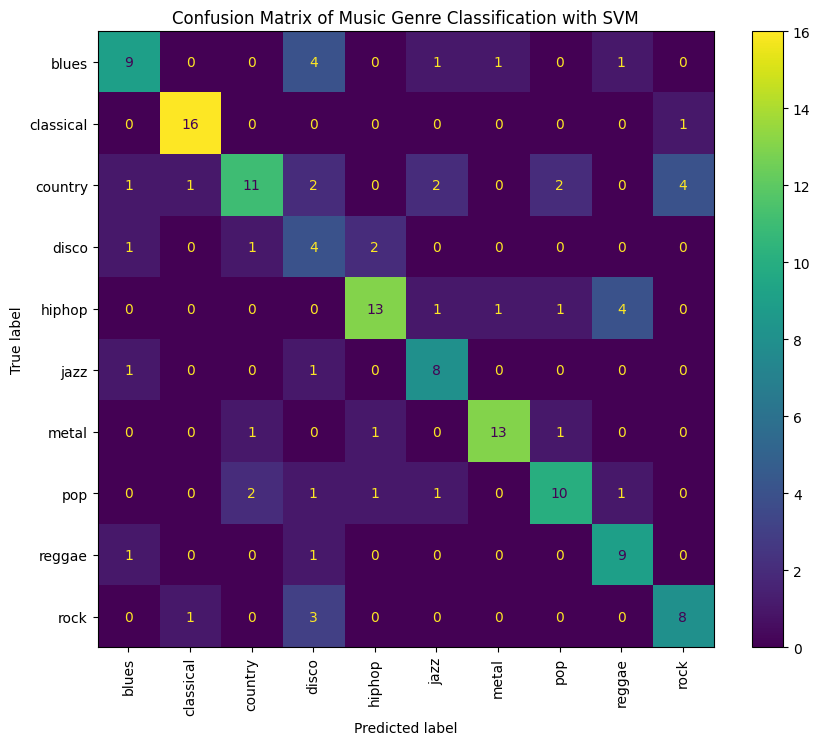

In [104]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example setup: 10 music genres
genres = ['blues',

'classical',

'country',

'disco',

'hiphop',

'jazz',

'metal',

'pop',

'reggae',

'rock',
]

conf_matrix_svm = confusion_matrix([np.argmax(i) for i in test_labels], test_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm, display_labels=genres)
disp.plot(ax=ax, cmap='viridis', xticks_rotation='vertical', colorbar=True)
plt.title("Confusion Matrix of Music Genre Classification with SVM")
plt.show()


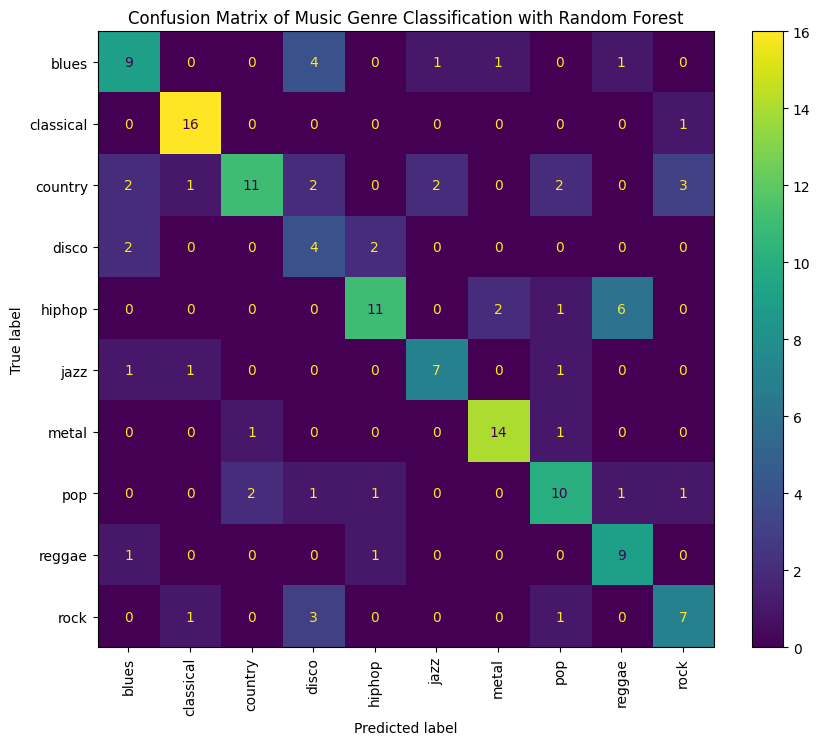

In [105]:
conf_matrix_rf = confusion_matrix([np.argmax(i) for i in test_labels], test_pred_rf)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=genres)
disp.plot(ax=ax, cmap='viridis', xticks_rotation='vertical', colorbar=True)
plt.title("Confusion Matrix of Music Genre Classification with Random Forest")
plt.show()

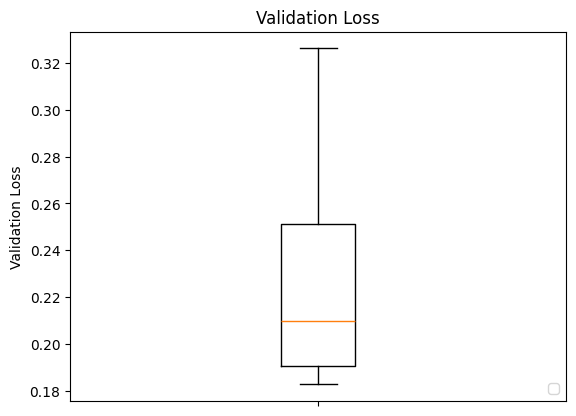

In [106]:
plt.boxplot(val_loss, showfliers=False)
plt.ylabel('Validation Loss')
plt.tick_params(axis='x', labelbottom=False) 
plt.title('Validation Loss')
plt.legend(loc='lower right')
plt.show()

<BarContainer object of 2 artists>

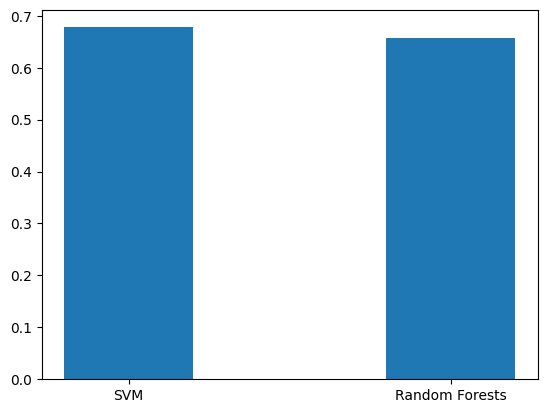

In [107]:
plt.bar(['SVM', 'Random Forests'], [accuracy_score([np.argmax(i) for i in test_labels], test_pred), accuracy_score([np.argmax(i) for i in test_labels], test_pred_rf)], width=0.4)

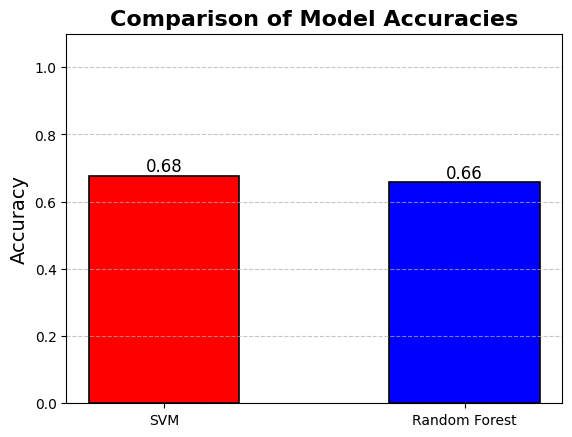

In [108]:
svm_accuracy = accuracy_score([np.argmax(i) for i in test_labels], test_pred)
rf_accuracy = accuracy_score([np.argmax(i) for i in test_labels], test_pred_rf)

# Bar plot data
methods = ['SVM', 'Random Forest']
accuracies = [svm_accuracy, rf_accuracy]
bars = plt.bar(methods, accuracies, width=0.5, color=['red', 'blue'], edgecolor='black', linewidth=1.2)

# Add value annotations
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=12)

# Add labels, title, and grid
plt.title('Comparison of Model Accuracies', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1.1)  # Ensure space above bars
plt.grid(axis='y', linestyle='--', alpha=0.7)